### Step 1: Introduction

- Problem statement: Detect fraudulent transactions.

- Dataset description: Fields like type, amount, oldbalanceOrg, isFraud.

- Goals: EDA, preprocessing, modeling, evaluation, model deployment.

In [6]:
# !pip install imblearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
# from imblearn.over_sampling import SMOTE
import joblib


**1-1** Loading dataset and exploring it

In [14]:
data = pd.read_csv("data/raw/fraud.csv")
data.head()
data.info()
data.describe()
counts = data['isFraud'].value_counts()
print("Class Distribution:\n", counts)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
Class Distribution:
 isFraud
0    6354407
1       8213
Name: count, dtype: int64


**1-2** Exploring Data Analysis(EDA)

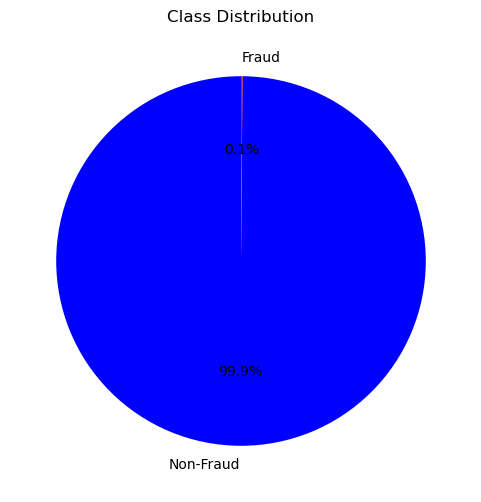

In [ ]:
#General Distribution
plt.figure(figsize=(6,6))
plt.pie(counts.values, labels=['Non-Fraud', 'Fraud'], 
        autopct='%1.1f%%', colors=['blue','red'], startangle=90)
plt.title("Class Distribution")
plt.show()

**Fraud vs Non-Fraud Transaction Distribution**

The charts below provide a detailed look at transaction patterns:

- **Fraudulent Transactions (Top Left)**  
  - Almost all fraud occurs in **TRANSFER** and **CASH_OUT** transaction types.  
  - Other transaction types such as **PAYMENT**, **DEBIT**, and **CASH_IN** show **no fraud cases** in the dataset.  

- **Non-Fraudulent Transactions (Top Right)**  
  - Non-fraud cases are present across all transaction types.  
  - The majority of legitimate transactions are **CASH_OUT**, followed by **PAYMENT** and **CASH_IN**.  

- **Fraud Rate (Bottom)**  
  - The fraud rate (fraudulent / total transactions) is significantly higher in **TRANSFER** and **CASH_OUT**, confirming they are the most **risky transaction types**.  
  - Other transaction types have a fraud rate of **0%**.  

📊 **Key Takeaway**:  
Fraud detection models should pay special attention to **TRANSFER** and **CASH_OUT transactions**, as they account for nearly all fraudulent activity in the dataset.


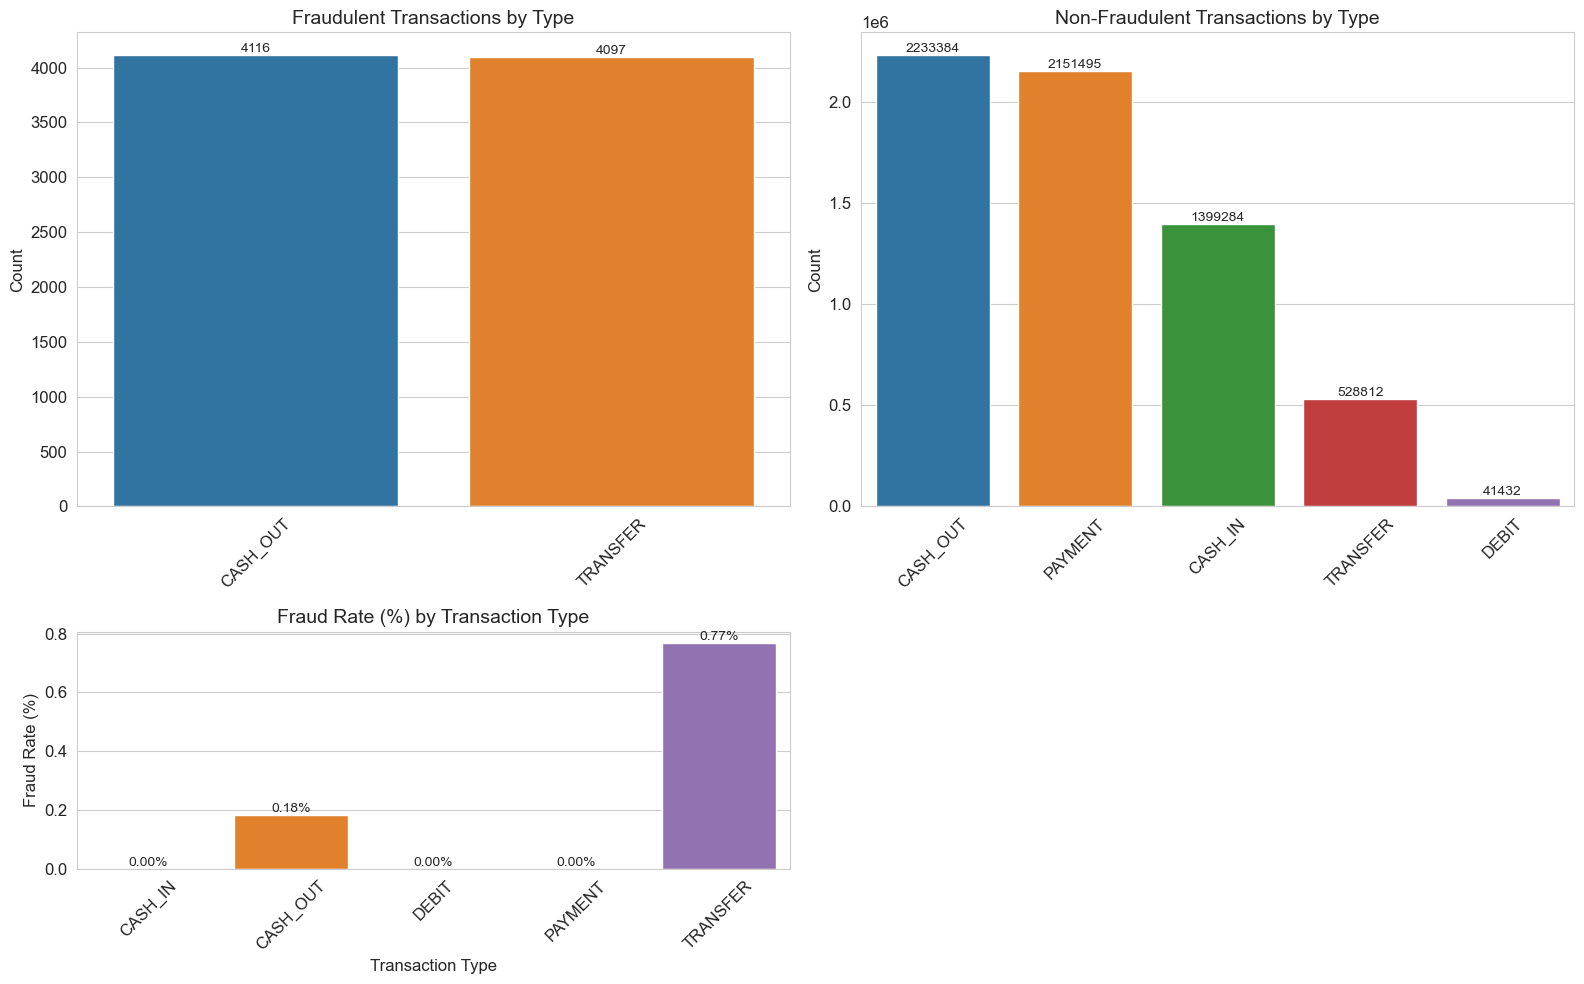

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

fraud_only = data[data["isFraud"] == 1]
nonfraud_only = data[data["isFraud"] == 0]

# Fraud rate per type
fraud_rate = (
    data.groupby("type")["isFraud"]
    .mean() * 100
).reset_index()

# Style settings
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})

fig, axes = plt.subplots(2, 2, figsize=(16,10), gridspec_kw={'height_ratios':[2,1]})

### Fraud count plot
sns.countplot(
    x="type", data=fraud_only, 
    order=fraud_only["type"].value_counts().index,
    
    ax=axes[0,0]
)
axes[0,0].set_title("Fraudulent Transactions by Type", fontsize=14)
axes[0,0].set_xlabel("")
axes[0,0].set_ylabel("Count")
axes[0,0].tick_params(axis='x', rotation=45)

# Add counts on bars
for p in axes[0,0].patches:
    axes[0,0].annotate(f'{int(p.get_height())}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='bottom', fontsize=10)

### Non-Fraud count plot
sns.countplot(
    x="type", data=nonfraud_only, 
    order=nonfraud_only["type"].value_counts().index,
    
    ax=axes[0,1]
)
axes[0,1].set_title("Non-Fraudulent Transactions by Type", fontsize=14)
axes[0,1].set_xlabel("")
axes[0,1].set_ylabel("Count")
axes[0,1].tick_params(axis='x', rotation=45)

# Add counts on bars
for p in axes[0,1].patches:
    axes[0,1].annotate(f'{int(p.get_height())}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='bottom', fontsize=10)

### Fraud rate plot
sns.barplot(
    x="type", y="isFraud", data=fraud_rate,
    
    ax=axes[1,0]
)
axes[1,0].set_title("Fraud Rate (%) by Transaction Type", fontsize=14)
axes[1,0].set_ylabel("Fraud Rate (%)")
axes[1,0].set_xlabel("Transaction Type")
axes[1,0].tick_params(axis='x', rotation=45)

# Add percentages on bars
for p in axes[1,0].patches:
    axes[1,0].annotate(f'{p.get_height():.2f}%', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='bottom', fontsize=10)

# Remove the unused subplot
fig.delaxes(axes[1,1])

plt.tight_layout()
plt.show()


Exploring the "Amount" distribution of the transactions is also important beacause fraudsters often behave differently in terms of amounts. 

- **Overall distribution**  
  - Fraudulent transactions are more frequent at **higher amounts**, visible when using a log scale.  
  - Non-fraud transactions are spread across all ranges but dominate smaller amounts.

- **TRANSFER vs CASH_OUT**  
  - Fraudulent **TRANSFER** transactions tend to occur at relatively **high amounts** compared to non-fraud transfers.  
  - In **CASH_OUT**, fraudulent amounts are also higher on average, but there is more overlap with legitimate ones.  

- **Boxplot insight**  
  - Fraudulent transactions show a **higher median amount** than non-fraudulent ones in both TRANSFER and CASH_OUT.  
  - Outliers are more extreme in fraud cases, confirming that fraudsters often attempt larger transactions.  

📊 **Key Takeaway**:  
Amount is an important predictor of fraud, especially in **TRANSFER** and **CASH_OUT**, where higher values are strongly associated with fraudulent activity.

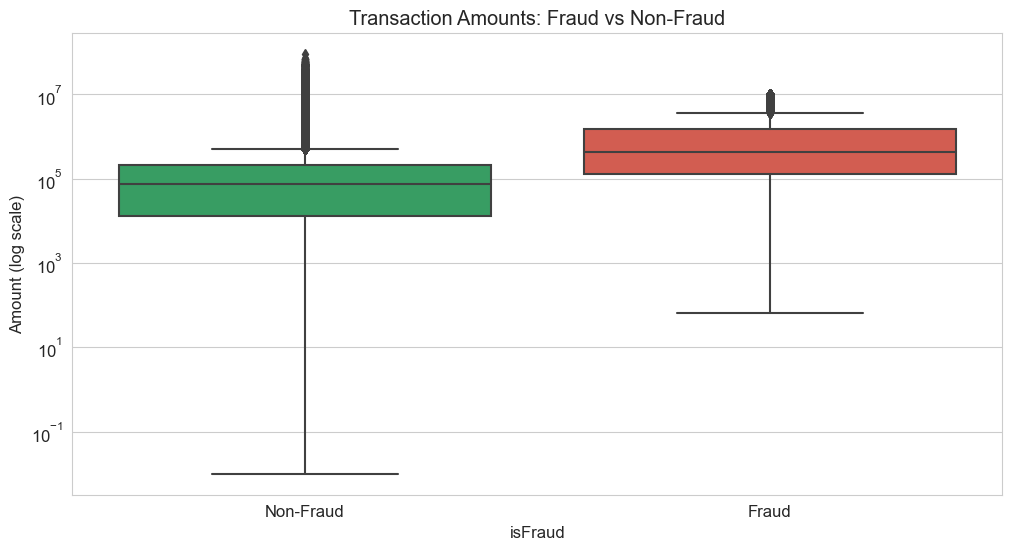

In [32]:
plt.figure(figsize=(12,6))
sns.boxplot(x="isFraud", y="amount", data=data_positive, palette=["#27AE60", "#E74C3C"])
plt.yscale("log")  # log scale for better visualization
plt.xticks([0,1], ["Non-Fraud", "Fraud"])
plt.title("Transaction Amounts: Fraud vs Non-Fraud")
plt.ylabel("Amount (log scale)")
plt.show()


"Most non-fraud transactions occur at lower amounts, whereas fraud transactions, though rare, often involve higher amounts, as shown by the boxplot.”

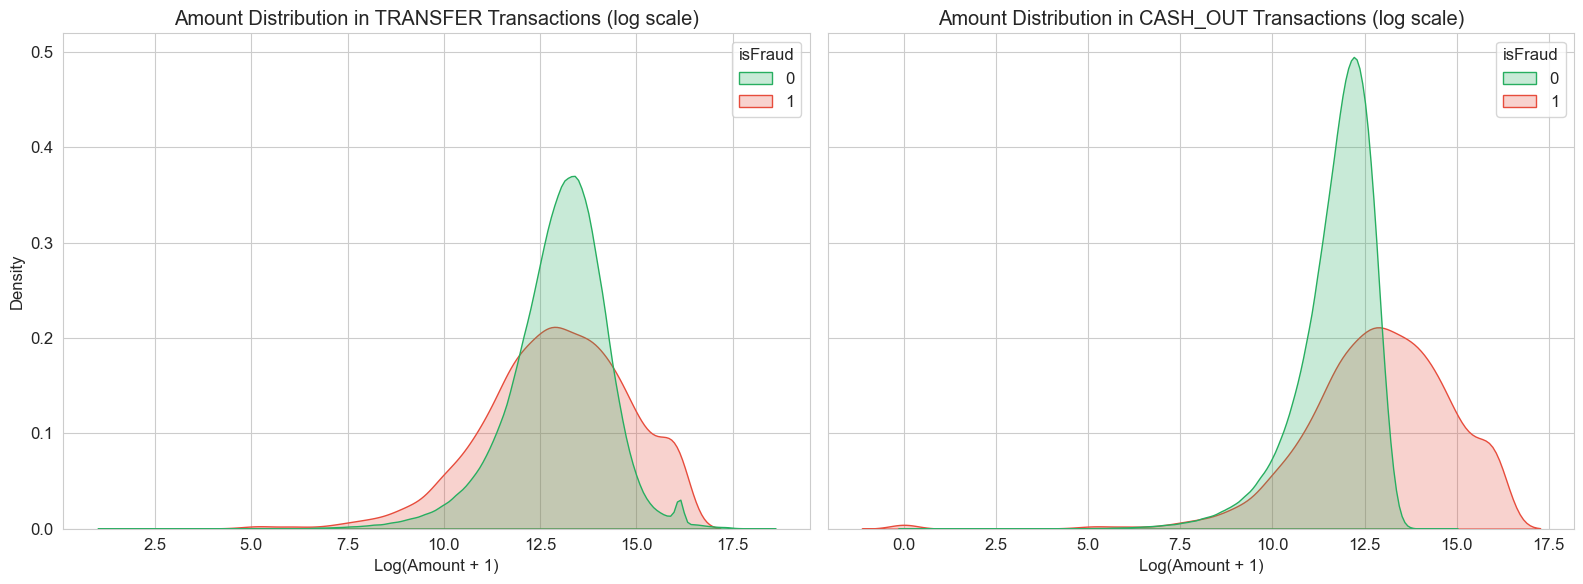

In [39]:
# Log-transform the amount to handle large range
data['log_amount'] = np.log1p(data['amount'])

fig, axes = plt.subplots(1, 2, figsize=(16,6), sharey=True)

# TRANSFER
sns.kdeplot(
    data=data[data["type"]=="TRANSFER"], 
    x="log_amount", 
    hue="isFraud", 
    fill=True, 
    palette=["#27AE60", "#E74C3C"], 
    ax=axes[0],
    common_norm=False  # scales each class separately
)

axes[0].set_title("Amount Distribution in TRANSFER Transactions (log scale)")
axes[0].set_xlabel("Log(Amount + 1)")
axes[0].set_ylabel("Density")

# CASH_OUT
sns.kdeplot(
    data=data[data["type"]=="CASH_OUT"], 
    x="log_amount", 
    hue="isFraud", 
    fill=True, 
    palette=["#27AE60", "#E74C3C"], 
    ax=axes[1],
    common_norm=False
)

axes[1].set_title("Amount Distribution in CASH_OUT Transactions (log scale)")
axes[1].set_xlabel("Log(Amount + 1)")

plt.tight_layout()
plt.show()


Observation: The KDE plots show that fraud transactions (red) have very similar amount distributions in both TRANSFER and CASH_OUT types.

Interpretation: Fraudsters tend to operate within similar amount ranges regardless of transaction type, suggesting that type alone may not strongly separate fraud from non-fraud.

**Balance Changes:**
Shows how the sender’s and receiver’s balances change. Fraud often drains the sender completely or creates unusual patterns in receiver balances.

C:\Users\niloa\AppData\Local\Temp\ipykernel_10504\3018320569.py:2: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=data, x='isFraud', y='diffOrig', jitter=True, palette=["#27AE60", "#E74C3C"])


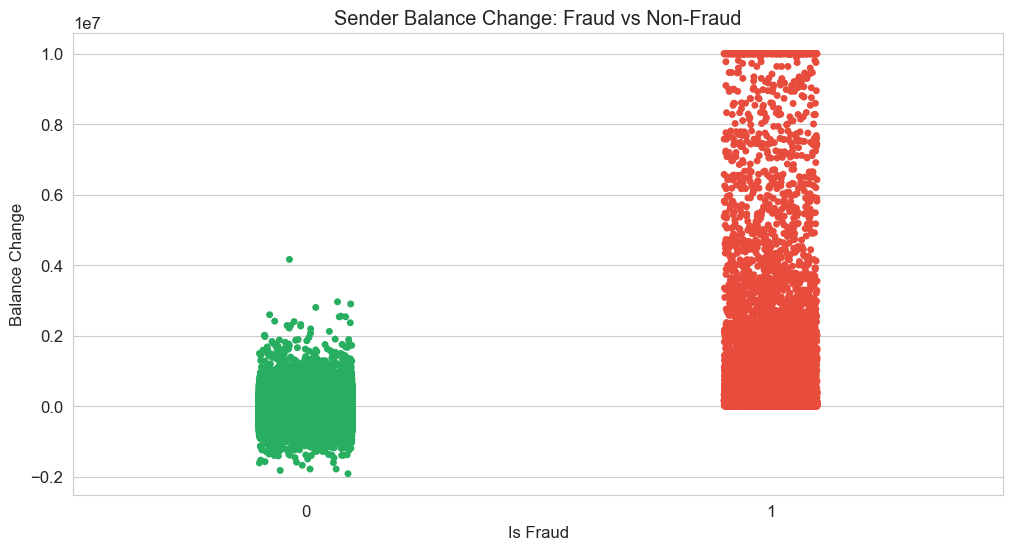

In [ ]:
# Create new features: balance differences
data['diffOrig'] = data['oldbalanceOrg'] - data['newbalanceOrig']
data['diffDest'] = data['newbalanceDest'] - data['oldbalanceDest']

plt.figure(figsize=(12,6))
sns.stripplot(data=data, x='isFraud', y='diffOrig', jitter=True, palette=["#27AE60", "#E74C3C"])
plt.title("Sender Balance Change: Fraud vs Non-Fraud")
plt.xlabel("Is Fraud")
plt.ylabel("Balance Change")
plt.show()


**Non-fraud (0):** points mostly between -0.2 and 0.2

✅ Meaning: for normal transactions, the sender’s balance barely changes after the transaction. This makes sense for payments and transfers where the money leaves the account in a predictable way.

**Fraud (1):** points spread between 0 and 1

⚠️ Meaning: fraudulent transactions often have larger or unusual changes in sender balances. This could happen if money is moved in unusual ways or the transaction is only partially recorded on the sender’s side.

**How did Fraud Transactions change the origin and destination accounts?**

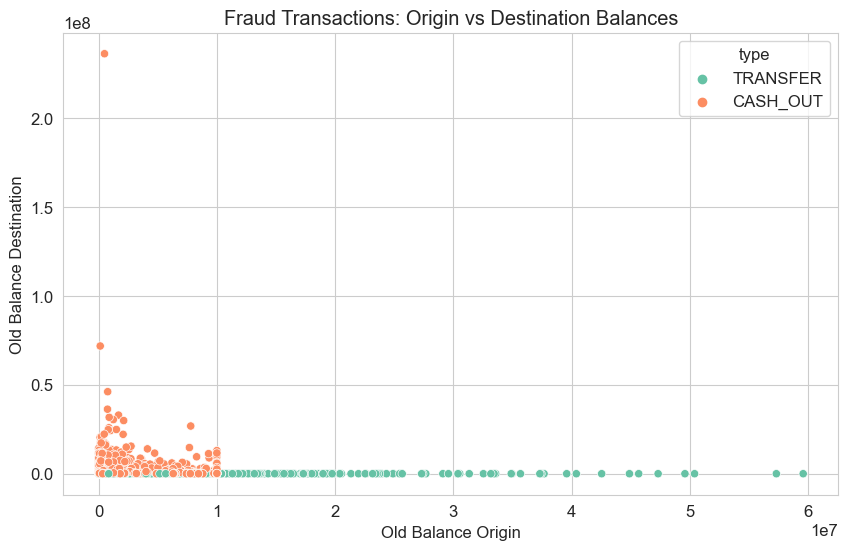

In [46]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=data[data['isFraud']==1], x='oldbalanceOrg', y='oldbalanceDest', hue='type', palette='Set2')
plt.title("Fraud Transactions: Origin vs Destination Balances")
plt.xlabel("Old Balance Origin")
plt.ylabel("Old Balance Destination")
plt.show()

This plot is only for fraud transactions in two categories: "TRANSFER" and "CASH_OUT". 

- x-axis (oldbalanceOrg): sender’s balance before the transaction

- y-axis (oldbalanceDest): receiver’s balance before the transaction

- hue (type): shows different types of fraudulent transactions with colors

We can see that most fraudulent transactions often involve empty or very low-balance accounts, which is common in money laundering or stolen accounts. Specifically, CASH_OUT transaction are highly clustered near the axes, whereas TRANSFER fraud could occur across a wider range of balances.
And with the "TRANSFER" type of transaction one can easily notice that the origin account has some balance (x-axis), but the destination account is always showing 0.
This likely means the fraudsters transfer money to accounts that start with zero balance, or the destination balance wasn’t recorded/updated.